# Glickman Homework 5: Training a Mini LLM

We complete Homework 5. The code below is based on the Session 5 content. We construct an LLM using PyTorch and examine its performance for different numbers of layers. We then plot and interpret the results mentioning areas of future work.

### Initial Setup

We first select a range of hyperparamters.

In [1]:
import torch
import torch.nn as nn
from torch.nn import functional as F
torch.manual_seed(1337)

# hyperparameters
batch_size = 16 # how many independent sequences will we process in parallel?
block_size = 32 # what is the maximum context length for predictions?
max_iters = 5000
eval_interval = 10
learning_rate = 1e-3
device = 'cuda' if torch.cuda.is_available() else 'cpu'
eval_iters = 200
n_embd = 64
n_head = 4 ## so head_size = 16
n_layer = 4
dropout = 0.0
# ------------

### Preprocess Data

We load text data. We use the tiny Shakespeare dataset. From Session 5, we know that the data is tokenzed according to a simple character based tokenizer. We split into training and test sets (90%/10% split).

In [2]:
with open('dataset/input.txt', 'r', encoding='utf-8') as f:
    text = f.read()

# here are all the unique characters that occur in this text
chars = sorted(list(set(text)))
vocab_size = len(chars)
# create a mapping from characters to integers
stoi = { ch:i for i,ch in enumerate(chars) }
itos = { i:ch for i,ch in enumerate(chars) }
encode = lambda s: [stoi[c] for c in s] # encoder: take a string, output a list of integers
decode = lambda l: ''.join([itos[i] for i in l]) # decoder: take a list of integers, output a string

# Train and test splits
data = torch.tensor(encode(text), dtype=torch.long)
n = int(0.9*len(data)) # first 90% will be train, rest val
train_data = data[:n]
val_data = data[n:]

# data loading
def get_batch(split):
    # generate a small batch of data of inputs x and targets y
    data = train_data if split == 'train' else val_data
    ix = torch.randint(len(data) - block_size, (batch_size,))
    x = torch.stack([data[i:i+block_size] for i in ix])
    y = torch.stack([data[i+1:i+block_size+1] for i in ix])
    x, y = x.to(device), y.to(device)
    return x, y

### Define Model Components

We employ a multi-head attention mechanism and a feedforward neural network within the model.

In [3]:
class Head(nn.Module):
    """ one head of self-attention """

    def __init__(self, head_size):
        super().__init__()
        self.key = nn.Linear(n_embd, head_size, bias=False)
        self.query = nn.Linear(n_embd, head_size, bias=False)
        self.value = nn.Linear(n_embd, head_size, bias=False)
        self.register_buffer('tril', torch.tril(torch.ones(block_size, block_size)))

        self.dropout = nn.Dropout(dropout)

    def forward(self, x):
        B,T,C = x.shape
        k = self.key(x)   # (B,T,C) 16,32,16
        q = self.query(x) # (B,T,C)
        # compute attention scores ("affinities")
        wei = q @ k.transpose(-2,-1) * C**-0.5 # (B, T, C) @ (B, C, T) -> (B, T, T)
        wei = wei.masked_fill(self.tril[:T, :T] == 0, float('-inf')) # (B, T, T)
        wei = F.softmax(wei, dim=-1) # (B, T, T)
        wei = self.dropout(wei)
        # perform the weighted aggregation of the values
        v = self.value(x) # (B,T,C)
        out = wei @ v # (B, T, T) @ (B, T, C) -> (B, T, C)
        return out

class MultiHeadAttention(nn.Module):
    """ multiple heads of self-attention in parallel """

    def __init__(self, num_heads, head_size):
        super().__init__()
        self.heads = nn.ModuleList([Head(head_size) for _ in range(num_heads)])
        self.proj = nn.Linear(n_embd, n_embd)
        self.dropout = nn.Dropout(dropout)

    def forward(self, x):
        out = torch.cat([h(x) for h in self.heads], dim=-1)
        out = self.dropout(self.proj(out))
        return out

class FeedFoward(nn.Module):
    """ a simple linear layer followed by a non-linearity """

    def __init__(self, n_embd):
        super().__init__()
        self.net = nn.Sequential(
            nn.Linear(n_embd, 4 * n_embd),
            nn.ReLU(),
            nn.Linear(4 * n_embd, n_embd), # Projection layer going back into the residual pathway
            nn.Dropout(dropout),
        )

    def forward(self, x):
        return self.net(x)

### Assemble Transformer Block

We assemble the above components into a transformer block.

In [4]:
class Block(nn.Module):
    """ Transformer block: communication followed by computation """

    def __init__(self, n_embd, n_head):
        # n_embd: embedding dimension, n_head: the number of heads we'd like
        super().__init__()
        head_size = n_embd // n_head
        self.sa = MultiHeadAttention(n_head, head_size)
        self.ffwd = FeedFoward(n_embd)
        self.ln1 = nn.LayerNorm(n_embd)
        self.ln2 = nn.LayerNorm(n_embd)

    def forward(self, x):
        x = x + self.sa(self.ln1(x))    # Communication
        x = x + self.ffwd(self.ln2(x))  # Computation
        return x

### Define Full Language Model (Transformer)

We assemble the blocks into the LLM. We combine token emneddings, positional embeddings, transformer blocks, and an output block.

In [5]:
# super simple language model
class LanguageModel(nn.Module):

    def __init__(self):
        super().__init__()
        # each token directly reads off the logits for the next token from a lookup table
        self.token_embedding_table = nn.Embedding(vocab_size, n_embd)
        self.position_embedding_table = nn.Embedding(block_size, n_embd)
        self.blocks = nn.Sequential(*[Block(n_embd, n_head=n_head) for _ in range(n_layer)])
        self.ln_f = nn.LayerNorm(n_embd) # final layer norm
        self.lm_head = nn.Linear(n_embd, vocab_size)

    def forward(self, idx, targets=None):
        B, T = idx.shape

        # idx and targets are both (B,T) tensor of integers
        tok_emb = self.token_embedding_table(idx) # (B,T,C)
        pos_emb = self.position_embedding_table(torch.arange(T, device=device)) # (T,C)
        x = tok_emb + pos_emb # (B,T,C)
        x = self.blocks(x) # (B,T,C)
        x = self.ln_f(x) # (B,T,C)
        logits = self.lm_head(x) # (B,T,vocab_size)

        if targets is None:
            loss = None
        else:
            B, T, C = logits.shape
            logits = logits.view(B*T, C)
            targets = targets.view(B*T)
            loss = F.cross_entropy(logits, targets)

        return logits, loss

    def generate(self, idx, max_new_tokens):
        # idx is (B, T) array of indices in the current context
        for _ in range(max_new_tokens):
            # crop idx to the last block_size tokens
            idx_cond = idx[:, -block_size:]
            # get the predictions
            logits, loss = self(idx_cond)
            # focus only on the last time step
            logits = logits[:, -1, :] # becomes (B, C)
            # apply softmax to get probabilities
            probs = F.softmax(logits, dim=-1) # (B, C)
            # sample from the distribution
            idx_next = torch.multinomial(probs, num_samples=1) # (B, 1)
            # append sampled index to the running sequence
            idx = torch.cat((idx, idx_next), dim=1) # (B, T+1)
        return idx



### Evaluating the Model

Here, we define the "estimate_loss" function. This splits training data into a true training set and a validation set. Then, we loop through batches of the training data to train the model. We calculate and return cross entropy loss.

In [6]:
@torch.no_grad()
def estimate_loss():
    out = {}
    model.eval()
    for split in ['train', 'val']:
        losses = torch.zeros(eval_iters)
        for k in range(eval_iters):
            X, Y = get_batch(split)
            logits, loss = model(X, Y)
            losses[k] = loss.item()
        out[split] = losses.mean()
    model.train()
    return out

### Adjusting Hyperparamters

Here we adjust the "n_layers" parameter to see its affect on perplexity (e to the power of cross entropy loss). We record both training and validation perplexity for increasing powers of 2.

In [7]:
train_perplexities = []
val_perplexities = []

for n_layer in [4, 8, 16, 32]:
    model = LanguageModel()
    model.to('cuda')
    loss = estimate_loss()
    train_perplexity = torch.exp(loss['train'])
    val_perplexity = torch.exp(loss['val'])
    train_perplexities.append(train_perplexity)
    val_perplexities.append(val_perplexity)
    print(f'Train Perplexity with {n_layer} Layers: {train_perplexity}')
    print(f'Validation Perplexity with {n_layer} Layers: {val_perplexity}\n')

Train Perplexity with 4 Layers: 82.40050506591797
Validation Perplexity with 4 Layers: 81.63420867919922

Train Perplexity with 8 Layers: 67.31242370605469
Validation Perplexity with 8 Layers: 67.38410186767578

Train Perplexity with 16 Layers: 75.40233612060547
Validation Perplexity with 16 Layers: 75.04157257080078

Train Perplexity with 32 Layers: 85.6507339477539
Validation Perplexity with 32 Layers: 85.83938598632812



### Results

We note that the perplexity did not follow a clear pattern when increasing the number of layers. We will revisit this code to further evaluate issues.

Text(0.5, 1.0, 'LLM Perplexity')

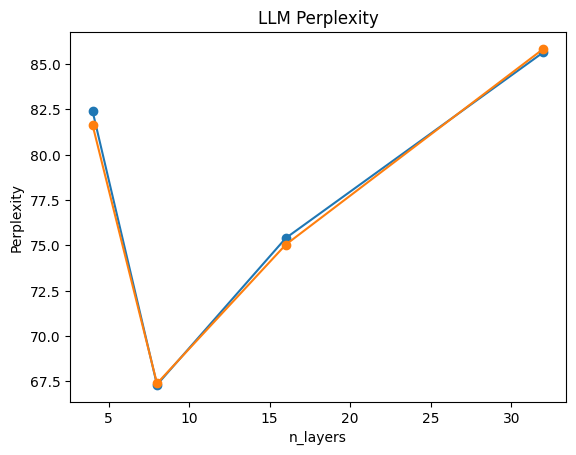

In [8]:
import matplotlib.pyplot as plt
%matplotlib inline

plt.plot([4, 8, 16, 32], train_perplexities, '-o')
plt.plot([4, 8, 16, 32], val_perplexities, '-o')
plt.xlabel('n_layers')
plt.ylabel('Perplexity')
plt.title('LLM Perplexity')

### Discussion

In practice, we would certainly want to train for multiple epochs, where each epoch is one complete pass through the training data. This model does not do that at this time. I would have implemented this, but since the model was quite complex, I felt that adapting the code for this purpose fell beyond the scope of a beginner assignment. Since the model class contained no explicit parameters and the training loop relied on the get_batch function (which together were reasonably complex for a beginner), I could not easily identify how to adjust the code for multiple epochs. In principle, for a given epoch, we would randomly shuffle and split the data into batches of a selected size, train the model, and record the loss. Then, we would repeat this for a given number of epochs. Based on previous assignments, we reasonably expect the loss to decline with multiple training epochs. Then, we would examine each complete training process for 4 values of the changed hyperparameter. I will certainly revisit this at a later time.